In [12]:
from pdastro import pdastrostatsclass,AnotB
import re
import numpy as np
import re,os,sys,shutil
import tweakreg_hack
from jwst import datamodels
from astropy.table import Table
import astropy.io.fits as fits
import matplotlib.pyplot as plt


#d2d is calculated when gaia is matched to the objects, and is the distance 
# between the objects and their matched gaia positions. Give a rough upper limit on 
# what a good match should fall into
d2d_max = None
dmag_max = 0.1
Nbright=None
def calc_dxdy(phot,d2d_max=None,dmag_max=None,Nbright=None, ixs=None):
    ixs = phot.getindices(ixs)
    if d2d_max is not None:
        ixs = phot.ix_inrange('d2d',None,3*d2d_max,indices=ixs)
    if dmag_max is not None:
        ixs = phot.ix_inrange('dmag',None,dmag_max,indices=ixs)
    if Nbright is not None:
        ixs_sort = phot.ix_sort_by_cols(['mag'],indices=ixs)
        ixs = ixs_sort[:Nbright]
        phot.write(columns=['mag'],indices=ixs)
        
    print(f'# of matched objects that pass initial cuts: {len(ixs)}')
    phot.t.loc[ixs,'dx_idl'] = phot.t.loc[ixs,'cat_x_idl'] - phot.t.loc[ixs,'x_idl']
    phot.t.loc[ixs,'ddec'] = 3600.0*(phot.t.loc[ixs,'cat_dec'] - phot.t.loc[ixs,'dec'])
    phot.t.loc[ixs,'dra'] = 3600.0*(phot.t.loc[ixs,'cat_ra'] - phot.t.loc[ixs,'ra'])*np.cos(np.deg2rad(phot.t.loc[ixs,'dec']))
    phot.t.loc[ixs,'dx'] = phot.t.loc[ixs,'cat_x'] - phot.t.loc[ixs,'x']
    phot.t.loc[ixs,'dy'] = phot.t.loc[ixs,'cat_y'] - phot.t.loc[ixs,'y']
    return(ixs)

def infoplots(phot,ixs_good,ixs_bad,dy_plotlim=(-4,4),dx_plotlim=(-4,4)):
    sp=[]
    xfigsize=15.0
    yfigsize=10.0
    plt.figure(figsize=(xfigsize,yfigsize))
    sp.append(plt.subplot(231))
    sp.append(plt.subplot(232))
    sp.append(plt.subplot(233))
    sp.append(plt.subplot(234))
    sp.append(plt.subplot(235))

    phot.t.loc[ixs_bad].plot.scatter('y','dx',ax=sp[0],ylim=dx_plotlim,color='red')
    phot.t.loc[ixs_good].plot.scatter('y','dx',ax=sp[0],ylim=dx_plotlim,ylabel='dx in pixels')
    phot.t.loc[ixs_bad].plot.scatter('x','dy',ax=sp[1],ylim=dy_plotlim,color='red')
    phot.t.loc[ixs_good].plot.scatter('x','dy',ax=sp[1],ylim=dy_plotlim,ylabel='dy in pixels')

    phot.t.loc[ixs_bad].plot.scatter('x','y',ax=sp[2],color='red')
    phot.t.loc[ixs_good].plot.scatter('x','y',ax=sp[2])
    
    phot.t.loc[ixs_bad].plot.scatter('sharpness','mag',ax=sp[3],color='red')
    phot.t.loc[ixs_good].plot.scatter('sharpness','mag',ax=sp[3])

    phot.t.loc[ixs_bad].plot.scatter('sharpness','dmag',ax=sp[4],color='red')
    phot.t.loc[ixs_good].plot.scatter('sharpness','dmag',ax=sp[4])

    return(sp)


In [4]:
###
### 
cal_image = 'test/pid1069_testonly/jw01069001001_02101_00001_nrca1_cal.fits' # 0.7 pixels stdev F070W
#cal_image = 'nrc24_calfiles/jw01073003001_02101_00001_nrca1_cal.fits' # 0.08 pixels stdev F150W
cal_image = 'coron_offsets/NRCA3_FULL_WEDGE_RND/jw01070001001_04101_00001_nrca3_cal.fits' #  
#cal_image = '/ifs/jwst/wit/nircam/commissioning/01069/dist_applied/v1/jw01069002002_04101_00002_nrcblong_cal.fits'
cal_image = '/ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_cal.fits'
cal_phot_filename = re.sub('cal\.fits$','cal.phot.txt',cal_image)
if cal_phot_filename == cal_image:
    raise RuntimeError(f'Could not determine photometry filename for {cal_image}')


In [5]:
### You only need to run this if the cal.phot.txt file does not exist yet!
from simple_jwst_phot import jwst_photclass
calphot=jwst_photclass()
calphot.verbose = 2
gaia_catname_for_testing='./LMC_gaia_DR3.nrcposs'
SNR_min = 10.0
if not os.path.isfile(cal_image):
    raise RuntimeError(f'file {cal_image} does not exist!')
calphot.run_phot(cal_image,gaia_catname_for_testing,SNR_min=SNR_min)
print('DONE!')


### Doing photometry on /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_cal.fits
Filename: /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     350   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [25224B]   
None
Instrument: NIRCAM, aperture:NRCA2_FULL_WEDGE_RND
Applying Pixel Area Map


2022-05-22 14:42:50,928 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCA2, Filter: F210M
FWHM for the filter F210M: 2.304 px


2022-05-22 14:42:51,751 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Background and rms using MMMBackground and MADStdBackgroundRMS: 0.009063118137419224 0.02984504926367354

Number of sources found in the image: 8036
-------------------------------------

radii:[4.608]pixels radius_sky_in:9.216 radius_sky_out:13.823999999999998  radius_for_mag:4.608
Performing aperture photometry for radius r = 4.608 px


2022-05-22 14:43:00,654 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:455: RuntimeWarning: invalid value encountered in sqrt
  error_poisson = np.sqrt(phot['aperture_sum'])

2022-05-22 14:43:00,656 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:467: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 7.0703727110000045
845 out of 8036 entries remain in photometry table
Matching Gaia catalog ./LMC_gaia_DR3.nrcposs
image objects are in x_idl=[-31.23,30.72] and y_idl=[-30.99,31.80] range
Keeping 342 out of 22544 catalog objects
Keeping 342  after removing NaNs from ra/dec
Saving /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_cal.phot.txt
DONE!


/ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_cal.phot.txt
outdir: /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1
NRCA2
filter:F210M
pupil: MASKRND
effective exptime: 365.05
# of matched objects that pass initial cuts: 738
dx median: -20.16074449999998 dy median: 1.1437720000000127


<AxesSubplot:xlabel='x', ylabel='dy'>

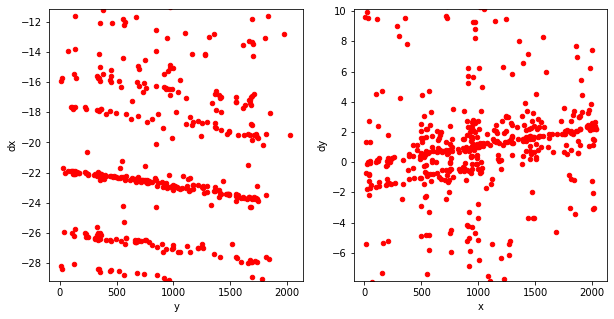

In [13]:
hdr = fits.getheader(cal_image)
#print(hdr)
outdir = os.path.dirname(cal_phot_filename)
print(f'{cal_phot_filename}\noutdir: {outdir}')
print(f'{hdr["DETECTOR"]}\nfilter:{hdr["FILTER"]}\npupil: {hdr["PUPIL"]}\neffective exptime: {hdr["EFFEXPTM"]}')

phot_cal = pdastrostatsclass()
phot_cal.load(cal_phot_filename)
ixs_cal = calc_dxdy(phot_cal,d2d_max=d2d_max,dmag_max=dmag_max,Nbright=Nbright)

sp=[]
xfigsize=10.0
yfigsize=5.0
plt.figure(figsize=(xfigsize,yfigsize))
sp.append(plt.subplot(121))
sp.append(plt.subplot(122))
 
cut_delta_pix = 3

dx_median = phot_cal.t.loc[ixs_cal,'dx'].median()
dy_median = phot_cal.t.loc[ixs_cal,'dy'].median()

print(f'dx median: {dx_median} dy median: {dy_median}')

# these are the limits for the y-axis for the plots
dy_plotlim = (dy_median-3*cut_delta_pix,dy_median+3*cut_delta_pix)
dx_plotlim = (dx_median-3*cut_delta_pix,dx_median+3*cut_delta_pix)

phot_cal.t.loc[ixs_cal].plot.scatter('y','dx',ax=sp[0],ylim=dx_plotlim,color='red')
phot_cal.t.loc[ixs_cal].plot.scatter('x','dy',ax=sp[1],ylim=dy_plotlim,color='red')


155 of 738 after dx cut
108 of 738 after dy cut
good objects left: 108
median dmag of good object: 0.0666325
median gaia_mag of good object: 18.826


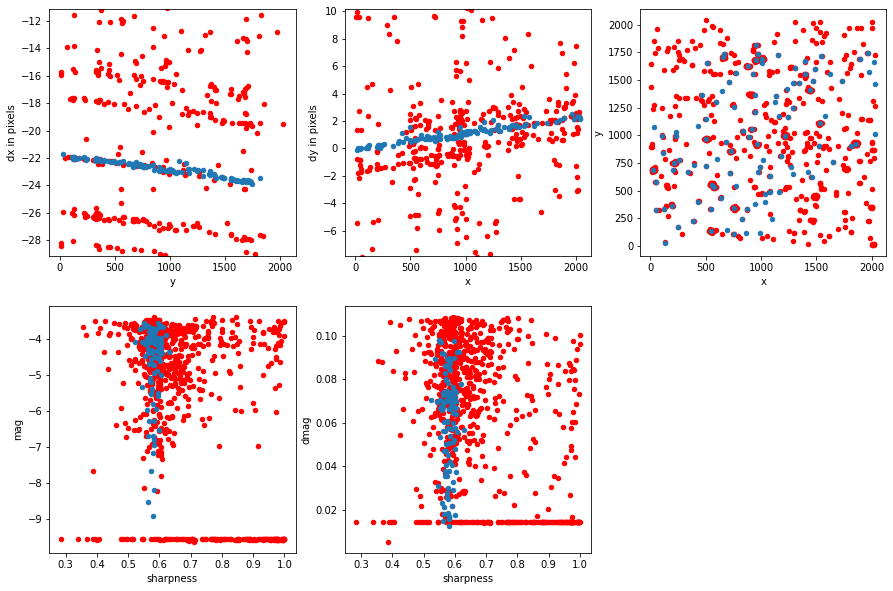

In [19]:
# get the values of dx at y=0 and y=2048!
##### BY HAND:
dxlim = (-22.2,-24.2)
width = 2.5
Nx=Ny=2048
do_dycut = True

slope = (dxlim[1]-dxlim[0])/Nx
intercept = dxlim[0]
def f(val):
    return(val*slope+intercept)

phot_cal.t['__tmp'] = phot_cal.t['dx'] - f(phot_cal.t['y'])
ixs_cal_good = phot_cal.ix_inrange('__tmp',-0.5*width,0.5*width,indices=ixs_cal)
print(f'{len(ixs_cal_good)} of {len(ixs_cal)} after dx cut')
if do_dycut:
    dylim = (-0.2,2.2)
    slope = (dylim[1]-dylim[0])/Ny
    intercept = dylim[0]
    phot_cal.t['__tmp'] = phot_cal.t['dy'] - f(phot_cal.t['y'])
    ixs_cal_good = phot_cal.ix_inrange('__tmp',-0.5*width,0.5*width,indices=ixs_cal_good)
    print(f'{len(ixs_cal_good)} of {len(ixs_cal)} after dy cut')
    

# get the bad data points
ixs_cal_bad = AnotB(phot_cal.getindices(),ixs_cal_good)

infoplots(phot_cal,ixs_cal_good,ixs_cal_bad,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)

#phot_cal.write(indices=ixs_cal_good)

print(f'good objects left: {len(ixs_cal_good)}')

# some extra info:
dmag_median = phot_cal.t.loc[ixs_cal_good,'dmag'].median()
gaia_mag_median = phot_cal.t.loc[ixs_cal_good,'gaia_mag'].median()
print(f'median dmag of good object: {dmag_median}')
print(f'median gaia_mag of good object: {gaia_mag_median}')


In [20]:
tweakreg = tweakreg_hack.TweakRegStep()
clobber = True
cal_image_dat = datamodels.open(cal_image)

tweakreg_image = f'{outdir}/'+re.sub('cal\.fits$','tweakregstep.fits',os.path.basename(cal_image))
print(f'{tweakreg_image}')
print(f'Setting output directory for tweakregstep.fits file to {outdir}')
tweakreg.output_dir = outdir
if not os.path.isdir(outdir):
    makepath(outdir)

if os.path.isfile(tweakreg_image):
    if clobber:
        os.remove(tweakreg_image)
    else:
        print('Not clobbering, so leaving.')
        sys.exit(1)
    
tweakreg.align_to_gaia = False
tweakreg.save_gaia_catalog = True
tweakreg.save_results = True
tweakreg.save_catalogs = True
tweakreg.snr_threshold = 50
tweakreg.separation = 9
tweakreg.searchrad = 0.5
tweakreg.minobj = 50
tweakreg.min_gaia = 30
# if you want to use x/yoffset, you need to set tweakreg.use2dhist=False
tweakreg.xoffset = 0
tweakreg.yoffset = 0
tweakreg.brightest = 200
tweakreg.fitgeometry = 'rshift'

tweakreg.already_matched = True
# phot_cal.t.loc[ixs_cal_good] is the table with the good matches!
t =  Table.from_pandas(phot_cal.t.loc[ixs_cal_good])
tweakreg.refcat = t
tweakreg.ref_racol = 'cat_ra'
tweakreg.ref_deccol = 'cat_dec'

### Provide your own source catalog, to be used in place of the default daofinder stuff. If you actually have a list
### of images, it's okay to provide a source catalog for each. 
cal_image_dat.source_catalog = t
cal_data = [cal_image_dat]
tweakreg.source_xcol = 'x'
tweakreg.source_ycol = 'y'

tweakreg.run(cal_data)
print('DONE')

2022-05-22 14:47:20,246 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


/ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_tweakregstep.fits
Setting output directory for tweakregstep.fits file to /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1


2022-05-22 14:47:29,630 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01070001001_04101_00001_nrca2_cal.fits>],).
2022-05-22 14:47:29,633 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 50, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 50, 'searchrad': 0.5, 'use2dhist': True, 'separation': 9, 'tolerance': 0.7, 'xoffset': 0, 'yoffset': 0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 30, 'save_gaia_catalog': True}
20

DONE


In [21]:
from simple_jwst_phot import jwst_photclass
tweakregphot=jwst_photclass()
tweakregphot.verbose = 2
gaia_catname_for_testing='./LMC_gaia_DR3.nrcposs'
align_gaia_SNR_min = 10.0
if not os.path.isfile(tweakreg_image):
    raise RuntimeError(f'BUG {tweakreg_image}')
tweakregphot.run_phot(tweakreg_image,gaia_catname_for_testing,SNR_min=align_gaia_SNR_min)
print('DONE!')


### Doing photometry on /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_tweakregstep.fits
Filename: /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_tweakregstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     352   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [117508230B]   
None
Instrument: NIRCAM, aperture:NRCA2_FULL_WEDGE_RND
Applying Pixel Area

2022-05-22 14:48:57,297 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCA2, Filter: F210M
FWHM for the filter F210M: 2.304 px


2022-05-22 14:48:58,042 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Background and rms using MMMBackground and MADStdBackgroundRMS: 0.009063118137419224 0.02984504926367354

Number of sources found in the image: 8036
-------------------------------------

radii:[4.608]pixels radius_sky_in:9.216 radius_sky_out:13.823999999999998  radius_for_mag:4.608
Performing aperture photometry for radius r = 4.608 px


2022-05-22 14:49:07,188 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:455: RuntimeWarning: invalid value encountered in sqrt
  error_poisson = np.sqrt(phot['aperture_sum'])

2022-05-22 14:49:07,189 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:467: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 7.1830089709999925
845 out of 8036 entries remain in photometry table
Matching Gaia catalog ./LMC_gaia_DR3.nrcposs
image objects are in x_idl=[-31.92,30.02] and y_idl=[-30.92,31.82] range
Keeping 349 out of 22544 catalog objects
Keeping 349  after removing NaNs from ra/dec
Saving /ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_tweakregstep.phot.txt
DONE!


# of matched objects that pass initial cuts: 738
dx median: -0.051667000000065855
dy median: -0.046398500000009335
good objects left: 143


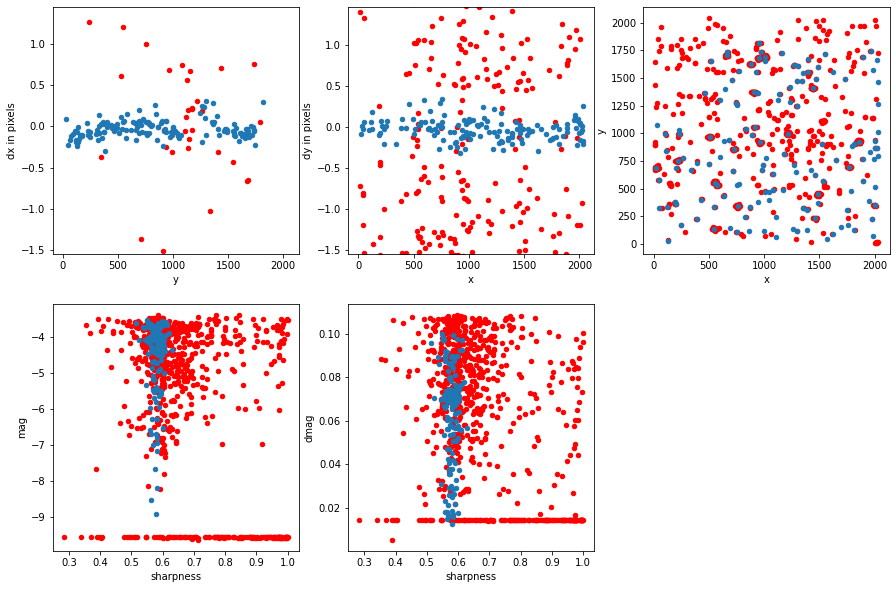

In [22]:
tweakreg_phot_filename = re.sub('fits$','phot.txt',tweakreg_image)
if tweakreg_phot_filename==tweakreg_image:
    raise RuntimeError(f'BUG!! {tweakreg_image}')

phot_tweakreg = pdastrostatsclass()

phot_tweakreg.load(tweakreg_phot_filename)

ixs_tweakreg = calc_dxdy(phot_tweakreg,d2d_max,dmag_max)

cut_delta_pix = 0.5

dx_median = phot_tweakreg.t.loc[ixs_tweakreg,'dx'].median()
dy_median = phot_tweakreg.t.loc[ixs_tweakreg,'dy'].median()
print(f'dx median: {dx_median}')
print(f'dy median: {dy_median}')
dy_plotlim = (dy_median-3*cut_delta_pix,dy_median+3*cut_delta_pix)
dx_plotlim = (dx_median-3*cut_delta_pix,dx_median+3*cut_delta_pix)

dxlim = (dx_median-cut_delta_pix,dx_median+cut_delta_pix)
dylim = (dy_median-cut_delta_pix,dy_median+cut_delta_pix)
ixs_tweakreg_good = phot_tweakreg.ix_inrange('dx',dxlim[0],dxlim[1])
ixs_tweakreg_good = phot_tweakreg.ix_inrange('dy',dylim[0],dylim[1],indices=ixs_tweakreg_good)
ixs_tweakreg_bad = AnotB(phot_tweakreg.getindices(),ixs_tweakreg_good)

infoplots(phot_tweakreg,ixs_tweakreg_good,ixs_tweakreg_bad,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)

print(f'good objects left: {len(ixs_tweakreg_good)}')



In [23]:
print('\n####################\n### dx')
#ixs_clean4average = phot_clear.ix_inrange('dx',0,3,indices=ixs_clear_cut)
phot_tweakreg.calcaverage_sigmacutloop('dx',verbose=3,indices=ixs_tweakreg_good,percentile_cut_firstiteration=85)
print(phot_tweakreg.statstring())
print('\n####################\n### dy')
phot_tweakreg.calcaverage_sigmacutloop('dy',verbose=3,indices=ixs_tweakreg_good,percentile_cut_firstiteration=85)
print(phot_tweakreg.statstring())
#phot_gaia.t['test_ddec'] = 3600.0*(phot_gaia.t['dec']-phot.t['dec'])
#phot_gaia.t.plot.scatter('dec','test_ddec')
#print(phot_gaia.t['test_ddec'])



####################
### dx
Keeping 143 out of 143, skippin 0 because of null values in columns dx
median: -0.040426
85.000000 percentile cut: max residual for cut: 0.138886
median: -0.049699
i:00 mean:-0.049699(0.006200) stdev:0.067919(0.004366) X2norm:1.00 Nchanged:0 Ngood:121 Nclip:22

mean: -0.044112
i:01 mean:-0.044112(0.007191) stdev:0.082614(0.005065) X2norm:1.00 Nchanged:12 Ngood:133 Nclip:10

mean: -0.039295
i:02 mean:-0.039295(0.007561) stdev:0.087853(0.005327) X2norm:1.00 Nchanged:3 Ngood:136 Nclip:7

mean: -0.041158
i:03 mean:-0.041158(0.007735) stdev:0.090206(0.005450) X2norm:1.00 Nchanged:1 Ngood:137 Nclip:6

mean: -0.041158
i:04 mean:-0.041158(0.007735) stdev:0.090206(0.005450) X2norm:1.00 Nchanged:0 Ngood:137 Nclip:6
i:04 mean:-0.041158(0.007735) stdev:0.090206(0.005450) X2norm:1.00 Nchanged:0 Ngood:137 Nclip:6

####################
### dy
Keeping 143 out of 143, skippin 0 because of null values in columns dy
median: -0.028692
85.000000 percentile cut: max residual for

In [32]:
import copy
xlim=(390,1039)
ylim=(1500,1839)

ixs_tweakreg_good_xylim=copy.deepcopy(ixs_tweakreg_good)
if xlim is not None:
    ixs_tweakreg_good_xylim = phot_tweakreg.ix_inrange('x',xlim[0],xlim[1],indices=ixs_tweakreg_good_xylim)
if ylim is not None:
    ixs_tweakreg_good_xylim = phot_tweakreg.ix_inrange('y',ylim[0],ylim[1],indices=ixs_tweakreg_good_xylim)

print('\n####################\n### dx')
#ixs_clean4average = phot_clear.ix_inrange('dx',0,3,indices=ixs_clear_cut)
phot_tweakreg.calcaverage_sigmacutloop('dx',verbose=3,indices=ixs_tweakreg_good_xylim,percentile_cut_firstiteration=85)
print(phot_tweakreg.statstring())
print('\n####################\n### dy')
phot_tweakreg.calcaverage_sigmacutloop('dy',verbose=3,indices=ixs_tweakreg_good_xylim,percentile_cut_firstiteration=85)
print(phot_tweakreg.statstring())



####################
### dx
Keeping 11 out of 11, skippin 0 because of null values in columns dx
median: -0.088553
85.000000 percentile cut: max residual for cut: 0.073213
median: -0.097865
i:00 mean:-0.097865(0.012944) stdev:0.036611(0.008629) X2norm:0.94 Nchanged:0 Ngood:9 Nclip:2

mean: -0.082587
i:01 mean:-0.082587(0.015491) stdev:0.046473(0.010392) X2norm:1.00 Nchanged:1 Ngood:10 Nclip:1

mean: -0.082587
i:02 mean:-0.082587(0.015491) stdev:0.046473(0.010392) X2norm:1.00 Nchanged:0 Ngood:10 Nclip:1
i:02 mean:-0.082587(0.015491) stdev:0.046473(0.010392) X2norm:1.00 Nchanged:0 Ngood:10 Nclip:1

####################
### dy
Keeping 11 out of 11, skippin 0 because of null values in columns dy
median: -0.075900
85.000000 percentile cut: max residual for cut: 0.129081
median: -0.116899
i:00 mean:-0.116899(0.021766) stdev:0.061563(0.014511) X2norm:0.94 Nchanged:0 Ngood:9 Nclip:2

mean: -0.104917
i:01 mean:-0.104917(0.020614) stdev:0.058305(0.013743) X2norm:1.00 Nchanged:0 Ngood:9 Nclip:2
